In [1]:
import os.path as op
import pandas as pd
import numpy as np
import re
import json
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
%run "../config.py" # this imports variables from config.py as global

In [2]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
text_column_name = 'text'
column_names = ['id_str', text_column_name, 'label']
stop_words = set(stopwords.words('english'))
ngram_range = (1, 2)
min_df = 3 # cut-off value for ignoring rare words
max_df = 1.0
max_features = 500
vectorizer = CountVectorizer(encoding='utf-8',
                             ngram_range=ngram_range,
                             stop_words=stop_words,
                             max_df=max_df,
                             min_df=min_df,
                             max_features=max_features)

In [7]:
# Load data
if data_filepath.endswith('.json'):
    data_arr = []
    with open(data_filepath, 'r') as f:
        for tweet in f:
            selected_row = []
            json_tweet = json.loads(tweet)
            try:
                # filter out retweets and non-English tweets
                if not json_tweet['retweeted'] and 'RT @' not in json_tweet[text_column_name] and json_tweet['lang'] == 'en':
                    for col in column_names:
                        selected_row.append(json_tweet[col])
                    data_arr.append(selected_row)
            except KeyError:
                pass
        data = pd.DataFrame(data_arr, columns=column_names)
elif data_filepath.endswith('.csv'):
    data = pd.read_csv(data_filepath)[column_names]
print(data.shape)
print(data.head(10))
tweets = data[text_column_name]

(195, 3)
                                              id_str  \
0  b'Z0FBQUFBQmVqMDFfZ1Z2YkRKN21XYTFRSGpjbzcxQlJs...   
1  b'Z0FBQUFBQmVqMDFfdDVkcDlwanRWZjlBb2N5Q183Z2NM...   
2  b'Z0FBQUFBQmVqMDFfVTRGd2pEbnJOX01Lc2E3T2VMeTVY...   
3  b'Z0FBQUFBQmVqMDFfM0lsVVk3S212MmpsOFVvZ0wtWERY...   
4  b'Z0FBQUFBQmVqMDFfU2hvdnNyMTg4T2NjTVBQMWxHV0Nw...   
5  b'Z0FBQUFBQmVqMDFfUkREY193aGp0amN6YWNpQWc2VzZ5...   
6  b'Z0FBQUFBQmVqMDFfcTAxZThrNjc3cnA3Z3A0RkdtQlZJ...   
7  b'Z0FBQUFBQmVqMDFfY21OLXlTRlVxX1hRTTlOemJHdXpU...   
8  b'Z0FBQUFBQmVqMDFfaDlZeWVzbEpXTUFaX0RaWF9oa3pH...   
9  b'Z0FBQUFBQmVqMDFfX1ladXZlMjg0a2dYcHJiTDQyNG92...   

                                                text  label  
0  Right wing media figures and groups are using ...      1  
1  Glasgow COP26 climate change conference postpo...      3  
2  @ErinOTooleMP Absolutely Erin. No way should h...      2  
3  Even during the coronavirus shut down, we aren...      1  
4  @OneOffDave1 @turpywurpy @scottgal @devisridha...      4  
5 

In [8]:
def preprocess(item):
    item = item.lower() # convert to lowercase
    item = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in item.split()]) # lemmatizing
    item = item.replace('-', ' ') # replace dashes with whitespace
    # remove numbers, punctuation, tags and URLs
    item = re.sub(r'[^a-zA-Z ]+|(@[A-Za-z0-9]+)|http\S+', '', item)
    return item

In [42]:
# get the distribution of top unigrams
def get_top_n_words(corpus, vectorizer, n=None):
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

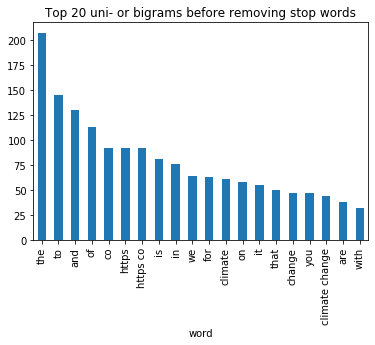

In [51]:
common_words_original = get_top_n_words(tweets, CountVectorizer(ngram_range=(1, 2)), 20)
df1 = pd.DataFrame(common_words_original, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot.bar(
    x='word', y='count', title='Top 20 uni- or bigrams before removing stop words')

In [9]:
preprocessed_tweets = tweets.apply(preprocess)
preprocessed_tweets.head(10)

0    right wing medium figure and group be use the ...
1    glasgow cop climate change conference postpone...
2    erinotoolemp absolutely erin no way should hik...
3    even during the coronavirus shut down we arent...
4    oneoffdave turpywurpy scottgal devisridhar the...
5    maybe this pandemic be the earths way of heal ...
6    how covid  might help u win the flight against...
7        coronavirus recycle to be dumped in landfill 
8    tonybaduy onionpirate peterdclack swcrisis mik...
9    engineeringvids unnecessary waste of money mon...
Name: text, dtype: object

In [44]:
X = vectorizer.fit_transform(preprocessed_tweets).toarray()
# Add other columns
X = np.c_[data['id_str'], X, data['label']]
vectorizer.get_feature_names()

['action',
 'air',
 'air pollution',
 'also',
 'amount',
 'amp',
 'anti',
 'april',
 'around',
 'back',
 'bad',
 'barackobama',
 'become',
 'big',
 'bin',
 'biodiversity',
 'building',
 'business',
 'call',
 'cant',
 'car',
 'carbon',
 'cause',
 'change',
 'change denier',
 'child',
 'city',
 'clear',
 'climate',
 'climate change',
 'climatechange',
 'close',
 'co',
 'consequence',
 'construction',
 'continue',
 'control',
 'coronavirus',
 'coronavirus covid',
 'could',
 'covid',
 'create',
 'crisis',
 'cut',
 'day',
 'deal',
 'death',
 'denial',
 'denier',
 'deniers',
 'didnt',
 'die',
 'distance',
 'doesnt',
 'dont',
 'drive',
 'due',
 'earth',
 'economy',
 'else',
 'emergency',
 'emission',
 'emission standard',
 'energy',
 'environment',
 'epa',
 'especially',
 'even',
 'every',
 'fall',
 'far',
 'find',
 'first',
 'food',
 'fossil',
 'fossil fuel',
 'fuel',
 'garden',
 'gas',
 'get',
 'give',
 'global',
 'global warm',
 'go',
 'good',
 'good thing',
 'google',
 'government',
 'gre

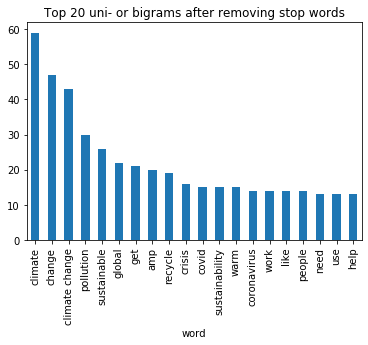

In [52]:
common_words_preprocessed = get_top_n_words(preprocessed_tweets, 
                                            CountVectorizer(ngram_range=(1, 2), stop_words=stop_words), 
                                            20)
df1 = pd.DataFrame(common_words_preprocessed, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot.bar(
    x='word', y='count', title='Top 20 uni- or bigrams after removing stop words')

In [53]:
# Split the matrix into random training and testing subsets
test_size = 0.25
train_fpath = op.join(op.dirname(data_filepath), 'train_data.csv')
test_fpath = op.join(op.dirname(data_filepath), 'test_data.csv')

X_train, X_test = train_test_split(X, test_size=test_size)
# "Label" instead of "label" to make sure it's a unique column name
X_train = pd.DataFrame(X_train, columns=['id_str']+vectorizer.get_feature_names()+['Label'])
X_test = pd.DataFrame(X_test, columns=['id_str']+vectorizer.get_feature_names()+['Label'])
print(X_train.shape, X_test.shape)
print(X_train.head())
# Save to csv files
X_train.to_csv(train_fpath, index=False)
X_test.to_csv(test_fpath, index=False)

(146, 224) (49, 224)
                                              id_str action air air pollution  \
0  b'Z0FBQUFBQmVqMDFfX1ladXZlMjg0a2dYcHJiTDQyNG92...      0   0             0   
1  b'Z0FBQUFBQmVqMDFfMjRON3NyOGNfWllwbUpKRW1GbGJa...      0   0             0   
2  b'Z0FBQUFBQmVqMDFfMHBJRVl6clloSndmWEIyQzh6TmZo...      0   0             0   
3  b'Z0FBQUFBQmVqMDFfNTE5a09Ba1FVSEtjVWd3RXB6M01h...      0   0             0   
4  b'Z0FBQUFBQmVqMDFfaXl2MTU0SE40N3hHSFJZVzd0dW1P...      0   0             0   

  also amount amp anti april around  ... wonder work worker world would year  \
0    0      0   0    0     0      0  ...      0    0      0     0     0    0   
1    0      0   0    0     0      0  ...      0    0      0     0     0    0   
2    0      0   0    0     0      0  ...      0    1      0     0     0    0   
3    1      0   0    0     0      0  ...      0    0      0     0     0    0   
4    0      0   0    0     0      0  ...      0    0      0     0     0    0   

  years yet